### Q1: Train and validate your own n-layer Neural Network on the Apparel dataset to predict the class label of a given apparel

### REPORT INCLUDED

In [1]:
import numpy as np
import pandas as pd
from math import sqrt, isnan, ceil
import matplotlib.pyplot as plt
import pickle

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# dataset = pd.read_csv('/content/drive/My Drive/apparel-trainval.csv')

In [2]:
dataset = pd.read_csv('../input_data/Apparel/apparel-trainval.csv')

In [3]:
rows, cols = dataset.shape
target = 'label'
classes = dataset['label'].nunique() #no of unique classes 0-9

### Standardising the dataset

In [4]:
def standardise(df):
    cols = df.columns
    for c in cols:
        if c != target:
            sd = df[c].std()
            mean = df[c].mean()
       
            if not isnan(sd) and sd != 0.0:
                df[c] = (df[c] - mean)/sd
            else:
                df[c] = 0
            
    return df

In [5]:
dataset = standardise(dataset)

In [6]:
train, validate = np.split(dataset, [int(.8*len(dataset))])
train_rows, train_cols = train.shape
labels = dataset[target].values #all actual classes of both train and validate

#### Convert dataframe to matrix without target column

In [7]:
def makeX(df):
    if target in df.columns:
        df = df.drop([target], axis=1)
    X = df.values
    return X

In [8]:
matrix = makeX(train)

In [9]:
validate_mat =  makeX(validate) #make matrix of validate dataframe

In [10]:
validate_actual = validate[target].values #actual class values of validate df

### Find one_hot_labels for training matrix

In [11]:
one_hot_labels = np.zeros((train_rows, classes))

for i in range(train_rows):  
    one_hot_labels[i, labels[i]] = 1
print "one_hot_labels: ", one_hot_labels.shape

one_hot_labels:  (48000, 10)


--> 0 T-shirt/top 1	Trouser 2 Pullover 3 Dress 4 Coat 5	Sandal 6 Shirt 7 Sneaker 8 Bag 9 Ankle boot

#### Function to make mini batches of input matrix and output matrix and specified batch size.
- First shuffle all the rows
- Then slice indices accordingly
- Returns a list of list of structure where one list comprises of corresponding i/p and o/p

In [12]:
def makeMiniBatches(inputs, outputs, batch_size):
  #optional to shuffle the rows
  #generate a random list of indices from 0 to train_size without replacement
    r_idx = np.random.choice(inputs.shape[0], inputs.shape[0], replace=False) #returns a list of shuffled nums from 0 to train_rows
    shuffle_input = inputs[r_idx] #shuffles the input array
    shuffle_output = outputs[r_idx]
    ########### optional ends ###########
    mini_batches = []
    for i in range (0, inputs.shape[0], batch_size):
        x = shuffle_input[i:i + batch_size, :]
        y = shuffle_output[i:i + batch_size, :]
        mini_batches.append([x, y])
    return mini_batches

### **FOR SINGLE HIDDEN LAYER**

In [13]:
class NeuralNetwork:
    def __init__(self, x, y, h):
        self.inputLayerSize = x
        self.outputLayerSize = y
        self.hiddenLayerSize = h
        self.weights_in_h = np.random.randn(x, h)  * sqrt(2.0/x)

        self.weights_h_op = np.random.randn(h, y)  * sqrt(2.0/h)  

        self.bias_1 = np.random.randn(h)
        self.bias_2 = np.random.randn(y)
        
  
    def feedForward(self, input_mat, activation_func):
        
        self.input_features = input_mat
    
        self.z2 = np.dot(input_mat, self.weights_in_h) + self.bias_1 #input to first hidden layer
        
        #output from first hidden layer
        if activation_func == 'sigmoid':
            self.a2 = self.sigmoid(self.z2)
        elif activation_func == 'tanh':
            self.a2 = np.tanh(self.z2)
        elif activation_func == 'relu':
            self.a2 = self.relu(self.z2)
        self.z3 = np.dot(self.a2, self.weights_h_op) + self.bias_2 #h1 -> o/p layer input
        y_pred = self.softmax(self.z3) #final output
        return y_pred
    
    def sigmoid(self, z):
        den = 1 + np.exp(-z)
        return 1/den
    
    def relu(self,x):
        return x * (x > 0)

    def relu_prime(self,x):
        return 1. * (x > 0)
    
    def saveWeights(self):
        np.savetxt("w1.txt", self.weights_in_h, fmt="%s")
        np.savetxt("w2.txt", self.weights_h_op, fmt="%s")
        
    def softmax(self,A):  
        expA = np.exp(A)
        return expA / expA.sum(axis=1, keepdims=True)

    def backprop(self, y_pred, y_act, activation_func):
      
      #phase 1
        cost_wrt_z3 = y_pred - y_act
        z3_wrt_who = self.a2

        cost_wrt_who = np.dot(z3_wrt_who.transpose(), cost_wrt_z3)
        cost_wrt_bias2 = cost_wrt_z3

      #phase 2

        z3_wrt_a2 = self.weights_h_op
        cost_wrt_a2 = np.dot(cost_wrt_z3, z3_wrt_a2.transpose())
        if activation_func == "sigmoid":
            a2_wrt_z2 = self.sigmoid(self.z2) * (1 - self.sigmoid(self.z2))
        elif activation_func == "tanh":
            a2_wrt_z2 = 1 - np.tanh(self.z2)**2
        elif activation_func == 'relu':
            a2_wrt_z2 = self.relu_prime(self.z2)
        z2_wrt_wih = self.input_features

        cost_wrt_wih = np.dot(z2_wrt_wih.transpose(), a2_wrt_z2 * cost_wrt_a2)
        cost_wrt_bias1 = cost_wrt_a2 * a2_wrt_z2
        return cost_wrt_wih, cost_wrt_bias1, cost_wrt_who, cost_wrt_bias2
    
    def updateWeights(self, cost_ih, cost_b1, cost_ho, cost_b2, alpha):
        self.weights_in_h -= alpha * cost_ih
        self.bias_1 -= alpha * cost_b1.sum(axis=0)
        self.weights_h_op -= alpha * cost_ho
        self.bias_2 -= alpha * cost_b2.sum(axis=0)
        
        
    def loss(self, y_pred, y_act):
        loss = np.sum(-y_act * np.log(y_pred))
        print ":", loss,") ",
        return loss
    
   

### Function to train 'single' layer neural network

In [ ]:
batchsize = 200 #divide the training set into mini batches, each of size <batchsize>

In [ ]:
def trainSingle(hNeurons, iterations, alpha, function_name):
    num_points_to_plot = 50
    mod = ceil(iterations // num_points_to_plot)
    if mod == 0:
        mod = 1
    err=[]
    ep_list = []
    
    
    ApparelNN = NeuralNetwork(cols - 1, classes, hNeurons)      


    for i in range(iterations):
        #make mini batches of the training set
        mini_batches = makeMiniBatches(matrix, one_hot_labels, batchsize) 
        #returns a list of list: [ [ <i/p matrix of 1st mini batch>, <o/p matrix of 1st mini batch>], ... ]

      #create empty matrices for all predictions and actual values
        all_pred = np.array([])
        all_act = np.array([])

        for one_mini_batch in mini_batches:
            inp = one_mini_batch[0]
            out = one_mini_batch[1]

            #prediction for this mini batch
            if function_name == 'sigmoid':
                y_hat = ApparelNN.feedForward(inp, 'sigmoid')

                #do back propagation
                c1, c2, c3, c4 = ApparelNN.backprop(y_hat, out, 'sigmoid')
            elif function_name == 'tanh':
                y_hat = ApparelNN.feedForward(inp, 'tanh')
                c1, c2, c3, c4 = ApparelNN.backprop(y_hat, out, 'tanh')
            elif function_name == 'relu':
                y_hat = ApparelNN.feedForward(inp, 'relu')
                c1, c2, c3, c4 = ApparelNN.backprop(y_hat, out, 'relu')
 
            #update the weights
            ApparelNN.updateWeights(c1, c2, c3, c4, alpha)

            #concatenate prediction and actual to bigger matrix
            all_pred = np.vstack([all_pred, y_hat]) if all_pred.size else y_hat
            all_act = np.vstack([all_act, out]) if all_act.size else out

        if i % mod == 0:
            print "(",i,
            ep_list.append(i)
            err.append(ApparelNN.loss(all_pred, all_act))
            print
    plt.figure(figsize = (5,8))
    plt.plot(ep_list, err)
    return ApparelNN

*SIGMOID 1 layer*

In [ ]:
sigmoid_1 = trainSingle(100, 5, 0.001, 'sigmoid')

In [ ]:
y_hat_validate = sigmoid_1.feedForward(validate_mat, 'sigmoid') #find prediction using feed forward

#### Function to find classes of predicted probabilities

In [22]:
def findClassesPred(prob_list):
    pred_classes = []
    rows = prob_list.shape[0]
    for i in range(rows):  
        label =prob_list[i].argmax() #assign the class whose value is maximum
        pred_classes.append(label)
    return pred_classes

In [ ]:
validate_prediction = findClassesPred(y_hat_validate)

#### Using Sklearn to find accuracy

In [21]:
from sklearn.metrics import accuracy_score

In [ ]:
print 'Accuracy Score :',accuracy_score(validate_actual, validate_prediction) * 100

*TANH 1 layer*

In [ ]:
tanh_1 = trainSingle(100, 5, 0.001, 'tanh')

In [ ]:
y_hat_validate = tanh_1.feedForward(validate_mat, 'tanh')

In [ ]:
validate_prediction = findClassesPred(y_hat_validate)

In [ ]:
print 'Accuracy Score tanh :',accuracy_score(validate_actual, validate_prediction) * 100

*ReLU 1 layer*

In [ ]:
relu_1 = trainSingle(100, 5, 0.001, 'relu')

In [ ]:
y_hat_validate = tanh_1.feedForward(validate_mat, 'relu')

In [ ]:
validate_prediction = findClassesPred(y_hat_validate)

In [ ]:
print 'Accuracy Score relu :',accuracy_score(validate_actual, validate_prediction) * 100

### **FOR MULTIPLE HIDDEN LAYER**

In [14]:
class NeuralNetworkMultiple:
    def __init__(self, x, y, h, n):
        self.inputLayerSize  = x
        self.outputLayerSize = y 
        self.hiddenLayerSize = h #all hidden layers have same size
        self.numHiddenLayers = n 

        self.weights = [] #list of numpy arrays
        self.bias    = [] # "same^"

        '''
        i/p -> h0 -> h1 -> h2 -> o/p    n=3
        w0    w1    w2    w3
        '''

        weights_in_h    = np.random.randn(x, h)  * sqrt(2.0/x) #w0
        bias_1          = np.random.randn(h)

        self.weights.append(weights_in_h)
        self.bias.append(bias_1)

        for layer in range(n-1):
            weights_intermediate = np.random.randn(h, h)  * sqrt(2.0/h) #w1 to wn-1
            bias_intermediate    = np.random.randn(h)
            self.bias.append(bias_intermediate)
            self.weights.append(weights_intermediate)

        weights_h_op    = np.random.randn(h, y)  * sqrt(2.0/h)  #b/w last hidden and o/p
        bias_2          = np.random.randn(y)

        self.bias.append(bias_2)
        self.weights.append(weights_h_op) #wn

  
    def feedForward(self, input_mat, activation_func):
        self.input_features = input_mat
        self.z2 = []
        self.a2 = []

        self.activation_func = activation_func
        '''
        w0         w1         w2         w3
        i/p ------> h0 ------> h1 ------> h2 ------> o/p -->   n=3
        z0    a0   z1    a1   z2   a2    z3   softmax
        '''
        z_0 = np.dot(input_mat, self.weights[0]) + self.bias[0] 
        self.z2.append(z_0)
        if activation_func == 'sigmoid':
            a_0  = self.sigmoid(z_0)
        elif activation_func == 'tanh':
            a_0 = np.tanh(z_0)
        elif activation_func == 'relu':
            a_0= self.relu(z_0)
        self.a2.append(a_0)
        num = self.numHiddenLayers-1

        for layer in range(num): #0,1
            z_intermediate = np.dot(self.a2[layer], self.weights[layer + 1]) + self.bias[layer + 1] 
            if activation_func == 'sigmoid':
                a_intermediate = self.sigmoid(z_intermediate)
            elif activation_func == 'tanh':
                a_intermediate= np.tanh(z_intermediate)
            elif activation_func == 'relu':
                a_intermediate= self.relu(z_intermediate)
            self.z2.append(z_intermediate)
            self.a2.append(a_intermediate)
        z_final = np.dot(self.a2[num], self.weights[num + 1]) + self.bias[num + 1]
        self.z2.append(z_final)
        y_pred = self.softmax(z_final) #final output

        return y_pred
    
    def sigmoid(self, z):
        den = 1 + np.exp(-z)
        return 1/den

    def relu(self,x):
        return x * (x > 0)

    def relu_prime(self,x):
        return 1. * (x > 0)
    
    def softmax(self,A):  
        expA = np.exp(A, dtype=np.float64)
        return expA / expA.sum(axis=1, keepdims=True)

    def backprop(self, y_pred, y_act, activation_func):
        num = self.numHiddenLayers
        
        cost = y_pred - y_act
        '''
                 w0         w1         w2         w3
        i/p <----- h0 <----- h1 <----- h2 <----- o/p <--   n=3
                 z0    a0   z1    a1   z2   a2    z3   softmax
        '''
        weight_der = []
        bias_der = []
        for layer in range(num, 0, -1):

            z3_wrt_who = self.a2[layer - 1]
            weight_der.append( np.dot(z3_wrt_who.transpose(), cost) )
            bias_der.append( np.average(cost, axis = 0))
            cost = np.dot(cost, self.weights[layer].transpose())

        if activation_func == "sigmoid":
            cost *= self.sigmoid(z3_wrt_who) * self.sigmoid(1 - z3_wrt_who)
        elif activation_func == "tanh":
            cost *= 1 - np.tanh(z3_wrt_who)**2
        elif activation_func == "relu":
            cost *= self.relu_prime(z3_wrt_who)
              
        weight_der.append( np.dot(self.input_features.transpose(), cost))
        bias_der.append( np.average(cost, axis = 0))
     
        weight_der = weight_der[::-1] 
        bias_der = bias_der[::-1]

        return weight_der, bias_der
    
    def saveWeights(self):
        
        path = "../output_data/"
        specs = self.activation_func + "_" + str(self.hiddenLayerSize) + "_" + str(self.numHiddenLayers)+"_"
        wts_file = path + specs + "weights.txt"
        bias_file = path + specs + "bias.txt"
        
        wtfile = open(wts_file, 'wb')
        pickle.dump(self.weights, wtfile)
        wtfile.close()
        bfile = open(bias_file, 'wb')
        pickle.dump(self.bias, bfile)
        bfile.close
    
    def updateWeights(self, weight, bias, alpha):
        num = self.numHiddenLayers

        for layer in range(num+1):
            self.weights[layer] -= alpha * weight[layer]
            self.bias[layer] -= alpha * bias[layer].sum(axis=0)
  
    def loss(self, y_pred, y_act):
        loss = np.sum(-y_act * np.log(y_pred))
        print ":", loss,") ",
        return loss
    
    def predict(self, input_mat, activation_func, weights, bias, numHiddenLayers):
        self.input_features = input_mat
        self.z2 = []
        self.a2 = []

        self.activation_func = activation_func
        '''
        w0         w1         w2         w3
        i/p ------> h0 ------> h1 ------> h2 ------> o/p -->   n=3
        z0    a0   z1    a1   z2   a2    z3   softmax
        '''
        z_0 = np.dot(input_mat, weights[0]) + bias[0] 
        self.z2.append(z_0)
        if activation_func == 'sigmoid':
            a_0  = self.sigmoid(z_0)
        elif activation_func == 'tanh':
            a_0 = np.tanh(z_0)
        elif activation_func == 'relu':
            a_0= self.relu(z_0)
        self.a2.append(a_0)
        num = numHiddenLayers-1

        for layer in range(num): #0,1
        #           print "layer: ",layer
            z_intermediate = np.dot(self.a2[layer], weights[layer + 1]) + bias[layer + 1] 
            if activation_func == 'sigmoid':
                a_intermediate = self.sigmoid(z_intermediate)
            elif activation_func == 'tanh':
                a_intermediate= np.tanh(z_intermediate)
            elif activation_func == 'relu':
                a_intermediate= self.relu(z_intermediate)
            self.z2.append(z_intermediate)
            self.a2.append(a_intermediate)

        z_final = np.dot(self.a2[num], weights[num + 1]) + bias[num + 1]
        self.z2.append(z_final)
        y_pred = self.softmax(z_final) #final output

        return y_pred

In [15]:
batchsize = 32 #divide the training set into mini batches, each of size <batchsize>

In [ ]:
# layer_loss_tanh = []
# layer_loss_sigmoid = []
# layer_loss_relu = []

### Function to train 'multiple' layer neural network

In [16]:
def trainNetwork(hNeurons, hiddenLayers, iterations, function_name, alpha):
    num_points_to_plot = 50
    mod = ceil(iterations // num_points_to_plot)
    if mod == 0:
        mod = 1
    ep_list = [] 
    err = []
    #initialize a NN with random weights
    ApparelNN2 = NeuralNetworkMultiple(cols - 1, classes, hNeurons, hiddenLayers)      

    for i in range(iterations):
        if i % mod == 0:
            print "iter: ",i,
        else:
            print "iter: ",i,
    #make mini batches of the training set
        mini_batches = makeMiniBatches(matrix, one_hot_labels, batchsize) 
    #returns a list of list: [ [ <i/p matrix of 1st mini batch>, <o/p matrix of 1st mini batch>], ... ]

    #create empty matrices for all predictions and actual values
        all_pred = np.array([])
        all_act = np.array([])
        mb = 0
        for one_mini_batch in mini_batches:
            mb += 1
#             print "mb: ", mb,
            inp = one_mini_batch[0]
            out = one_mini_batch[1]
            
            if function_name == 'tanh':
                #prediction for this mini batch
                y_hat = ApparelNN2.feedForward(inp, 'tanh')

                #do back propagation
                c1, c2 = ApparelNN2.backprop(y_hat, out, 'tanh')
            elif function_name == 'sigmoid':
                y_hat = ApparelNN2.feedForward(inp, 'sigmoid')
                c1, c2 = ApparelNN2.backprop(y_hat, out, 'sigmoid')
            elif function_name == 'relu':
                y_hat = ApparelNN2.feedForward(inp, 'relu')
                c1, c2 = ApparelNN2.backprop(y_hat, out, 'relu')
                

            #update the weights
            ApparelNN2.updateWeights(c1, c2, alpha)

            #concatenate prediction and actual to bigger matrix
            all_pred = np.vstack([all_pred, y_hat]) if all_pred.size else y_hat
            all_act = np.vstack([all_act, out]) if all_act.size else out

        if i % mod == 0:
            print "(",i,
            ep_list.append(i)
            err.append(ApparelNN2.loss(all_pred, all_act))
            print
    plt.figure(figsize = (8,6))
    plt.plot(ep_list, err)
    plt.grid(True)
#     if function_name == 'tanh':
#         layer_loss_tanh.append(err[-1])
#     elif function_name == 'sigmoid':
#         layer_loss_sigmoid.append(err[-1])
#     elif function_name == 'relu':
#         layer_loss_relu.append(err[-1])
    

    ApparelNN2.saveWeights()
    return ApparelNN2

### Task: Contrast the effect of using different activation functions on the validation data.Use ReLU, Sigmoid & Tanh as activation functions in the hidden layers

*Tanh*

In [17]:
function_name = 'tanh'

iter:  0 ( 0 : 23816.69397201646 ) 
iter:  1 ( 1 : 18573.67748532426 ) 
iter:  2 ( 2 : 17097.671730008817 ) 
iter:  3 ( 3 : 16068.334805656039 ) 
iter:  4 ( 4 : 15340.939904593472 ) 


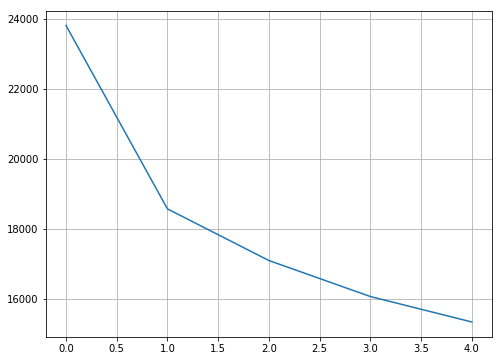

In [18]:
ApparelNN2=trainNetwork(100, 1, 5, function_name, 0.001)

In [19]:
y_hat_validate = ApparelNN2.feedForward(validate_mat, function_name) #find prediction using feed forward

In [23]:
validate_prediction = findClassesPred(y_hat_validate)

In [24]:
print 'Accuracy Score Tanh :',accuracy_score(validate_actual, validate_prediction) * 100

Accuracy Score Tanh : 87.075


*Sigmoid*

In [25]:
function_name = 'sigmoid'

iter:  0

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: overflow encountered in exp


 ( 0 : 34317.48547939117 ) 
iter:  1 ( 1 : 29742.15281866989 ) 
iter:  2 ( 2 : 28668.71117771229 ) 
iter:  3 ( 3 : 28809.815876992652 ) 
iter:  4 ( 4 : 29100.870141534324 ) 


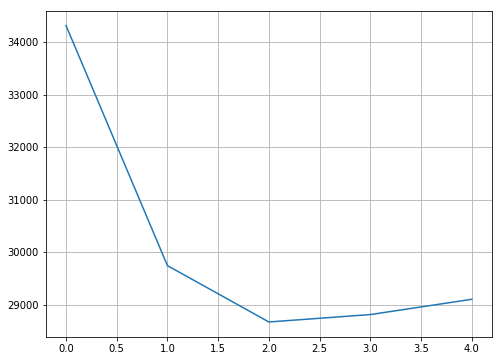

In [28]:
ApparelNN2=trainNetwork(50, 2, 5, function_name, 0.04)

In [29]:
y_hat_validate = ApparelNN2.feedForward(validate_mat, function_name) #find prediction using feed forward

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: overflow encountered in exp


In [30]:
validate_prediction = findClassesPred(y_hat_validate)

In [31]:
print 'Accuracy Score Sigmoid :',accuracy_score(validate_actual, validate_prediction) * 100

Accuracy Score Sigmoid : 77.80833333333334


*ReLU*

In [32]:
function_name = 'relu'
batchsize = 250

iter:  0 ( 0 : 29406.971884125716 ) 
iter:  1 ( 1 : 20501.945512023245 ) 
iter:  2 ( 2 : 18685.70828853157 ) 
iter:  3 ( 3 : 17440.235725282746 ) 
iter:  4 ( 4 : 16589.931759829902 ) 


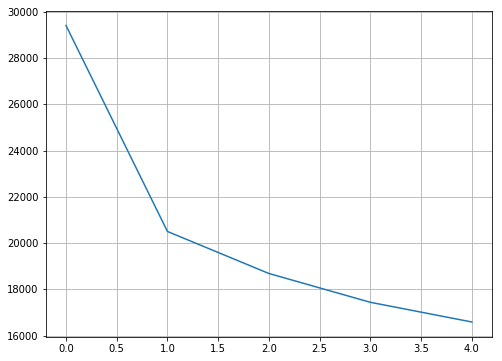

In [33]:
ApparelNN2=trainNetwork(50, 2, 5, function_name, 0.0004)

In [34]:
y_hat_validate = ApparelNN2.feedForward(validate_mat, function_name) #find prediction using feed forward

In [35]:
validate_prediction = findClassesPred(y_hat_validate)

In [36]:
print 'Accuracy Score Relu :',accuracy_score(validate_actual, validate_prediction) * 100

Accuracy Score Relu : 86.50833333333333


- The following lists of loss are for 100 hidden nodes, 1-5 hidden layers, 512 batch size 0.001 alpha
    - While playing with the NN, these values may get overwritten, hence storing them.

In [37]:
layer_loss_sigmoid = [20004.229911252827, 22245.46818591282, 29106.456564960947, 71177.26299006863, 87759.93031340423]
layer_loss_tanh = [16890.989598702894, 17693.14611468205, 18923.397562868773, 27107.700656488792, 45557.1123712116]

### Task: Play with your neural network to report the best performing architecture forthe given task.  Also, include the activation function, loss function used in the report

    function name | hidden layers | hidden nodes | batchsize | iter     | alpha    | accuracy
    -    sigmoid           1                38            512       5       0.001     81.7
    -    sigmoid           1               100            512       5       0.01      82.6
    -    sigmoid           1               100            512       5       0.001     84.85
    -    tanh              1                38            512       5       0.001     85.4
    -    tanh              1               100            512       5       0.001     86.64
    -    tanh              1               100            512       5       0.01      79.325
    -    tanh              1                64             32       5       0.001     86.0
    -    relu              1                32              8       5       0.001     85.4
    -    sigmoid           2                19            512       5       0.001     67.6
    -    sigmoid           2                50            512       5       0.001     80.125
    -    tanh              2                19            512       5       0.001     79.8
    -    tanh              2                50            512       5       0.001     84.8
    -    tanh              2                32             40       5       0.002     83.2
    -    relu              2               100             40       5       0.001     54.9
    -    sigmoid           3               100             40       5       0.005     82.75
    -    sigmoid           3                50             34       5       0.01      77.70
    -    tanh              3                64             32       5       0.001     84.0
    -    tanh              3                64           1024       5       0.001     76.2
    -    relu              3                50            250       5       0.00001   79.2
    -    relu              4                50            250       5       0.00001   80.15
    -    tanh              4                50            250       5       0.00001   69.01

#### Function to plot loss vs layer

--> While running Relu activation function, different learning rates give divide by zero exception, hence nan as output.

In [38]:
def plot(ysigmoid, ytanh):
    x = [1,2,3,4,5]
    fig, ax = plt.subplots(figsize = (8,6))

    ax.plot(x, ysigmoid, label="sigmoid")
    ax.plot(x, ytanh, label="tanh")
    ax.legend(loc=2) # upper left corner
    ax.set_xlabel('layer')
    ax.set_ylabel('loss')
    ax.set_title('loss vs layer')
    ax.grid(True)

### Task: Report how the number of layers affects the performances of the model.  Plot number of layers vs prediction loss graph

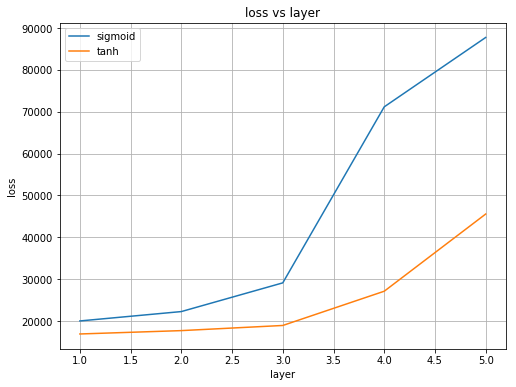

In [39]:
plot(layer_loss_sigmoid, layer_loss_tanh)

### TESTING

In [40]:
test = pd.read_csv('../input_data/Apparel/apparel-test.csv')

In [41]:
test = standardise(test)

In [ ]:
# print "shape; ",test.shape
# print "cols: ",test.columns

In [42]:
path = "../output_data/"
specs = 'tanh' + "_" + str(100) + "_" + str(1)+"_"
wts_file = path + specs + "weights.txt"
bias_file = path + specs + "bias.txt"

wtfile = open(wts_file, 'rb')
weights = pickle.load(wtfile)
wtfile.close()


bfile = open(bias_file, 'rb')
bias = pickle.load(bfile)
bfile.close()

In [43]:
test_mat = makeX(test)

In [44]:
test_predict = ApparelNN2.predict(test_mat, 'tanh', weights, bias, 1)

In [45]:
test_prediction = findClassesPred(test_predict)

In [46]:
import csv

with open('../output_data/2018202010_prediction.csv', 'wb') as to_write:
    wr = csv.writer(to_write, delimiter = '\n')
    wr.writerow(test_prediction)